In [5]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [6]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


np.random.seed(seed)
tf.random.set_seed(seed)

1 Physical GPUs, 1 Logical GPUs


In [8]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_7   willr_7     OBV_7  labels
0  2000-01-12     0.898039  0.958972  0.604167  0.653426     2.0
1  2000-01-13     0.960784  0.965065  0.770834  0.672066     2.0
2  2000-01-14     0.952941  0.967502  0.878049  0.663181     2.0
3  2000-01-17     0.952941  0.969329  0.791667  0.663181     2.0
4  2000-01-18     0.905882  0.957906  0.352941  0.657046     2.0


In [9]:
df.set_index('Date', inplace=True)

In [10]:
sequential_data = []
labels = []
data_15 = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append([i[0:-1]])
        sequential_data.append(data_15)
        labels.append(i[-1])
        data_15 = data_15[1:]
    
    else:
        data_15.append([i[0:-1]])
        count += 1

In [11]:
X = sequential_data
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4984, 15, 4)

In [12]:
X[0]

array([[0.89803913, 0.95897235, 0.60416668, 0.65342623],
       [0.96078432, 0.96506478, 0.77083361, 0.67206626],
       [0.95294115, 0.96750175, 0.87804879, 0.66318055],
       [0.95294115, 0.96932947, 0.79166663, 0.66318055],
       [0.9058823 , 0.9579062 , 0.35294124, 0.65704633],
       [0.89803913, 0.94720639, 0.19999949, 0.64543071],
       [0.86666662, 0.93065216, 0.06250022, 0.63208326],
       [0.9058823 , 0.92889821, 0.37500015, 0.64310542],
       [0.85882345, 0.91478868, 0.17647026, 0.62854408],
       [0.8352941 , 0.89780951, 0.05555579, 0.62190272],
       [0.80392158, 0.87654577, 0.1666672 , 0.60723348],
       [0.8117646 , 0.86273027, 0.2777776 , 0.61638355],
       [0.82745093, 0.85663336, 0.38888907, 0.62169771],
       [0.85098028, 0.85845768, 0.5555552 , 0.6311553 ],
       [0.8117646 , 0.84916421, 0.31249993, 0.62267962]])

In [13]:
y = labels
y = np.array(y)
y.shape

(4984,)

In [14]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                   y,
                                                                   test_size = 0.2,
                                                                   random_state=seed)

In [15]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [16]:
import time

EPOCHS = 300  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(256, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.2, seed=seed))

model.add(Dense(64, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.2, seed=seed))

# model.add(Dense(32, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [75]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

Epoch 1/300
32/32 [==============================] - 1s 42ms/step - loss: 0.2801 - accuracy: 0.3732 - val_loss: 0.3006 - val_accuracy: 0.0481
Epoch 2/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2346 - accuracy: 0.3256 - val_loss: 0.2878 - val_accuracy: 0.0481
Epoch 3/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2277 - accuracy: 0.3215 - val_loss: 0.2731 - val_accuracy: 0.0481
Epoch 4/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2184 - accuracy: 0.3511 - val_loss: 0.2641 - val_accuracy: 0.0481
Epoch 5/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2159 - accuracy: 0.3318 - val_loss: 0.2544 - val_accuracy: 0.0622
Epoch 6/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2098 - accuracy: 0.3313 - val_loss: 0.2462 - val_accuracy: 0.0612
Epoch 7/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2084 - accuracy: 0.3286 - val_loss: 0.2368 - val_accuracy: 0.1073
Epoch 

32/32 [==============================] - 0s 11ms/step - loss: 0.1488 - accuracy: 0.4680 - val_loss: 0.2196 - val_accuracy: 0.3300
Epoch 59/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1505 - accuracy: 0.4329 - val_loss: 0.2155 - val_accuracy: 0.3470
Epoch 60/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1482 - accuracy: 0.4291 - val_loss: 0.2082 - val_accuracy: 0.3551
Epoch 61/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1468 - accuracy: 0.4570 - val_loss: 0.2018 - val_accuracy: 0.3611
Epoch 62/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1474 - accuracy: 0.4359 - val_loss: 0.2102 - val_accuracy: 0.3601
Epoch 63/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1464 - accuracy: 0.4600 - val_loss: 0.2106 - val_accuracy: 0.3490
Epoch 64/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1430 - accuracy: 0.4592 - val_loss: 0.2129 - val_accuracy: 0.3460
Epoch 65/300

32/32 [==============================] - 0s 11ms/step - loss: 0.1226 - accuracy: 0.5934 - val_loss: 0.2280 - val_accuracy: 0.4183
Epoch 116/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1361 - accuracy: 0.5169 - val_loss: 0.2272 - val_accuracy: 0.4032
Epoch 117/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1250 - accuracy: 0.5410 - val_loss: 0.2105 - val_accuracy: 0.4504
Epoch 118/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1285 - accuracy: 0.5157 - val_loss: 0.2095 - val_accuracy: 0.4293
Epoch 119/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1269 - accuracy: 0.5463 - val_loss: 0.2055 - val_accuracy: 0.4794
Epoch 120/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1201 - accuracy: 0.5724 - val_loss: 0.2147 - val_accuracy: 0.4453
Epoch 121/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1197 - accuracy: 0.5586 - val_loss: 0.2067 - val_accuracy: 0.4764
Epoch 

Epoch 172/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0941 - accuracy: 0.6835 - val_loss: 0.2150 - val_accuracy: 0.6018
Epoch 173/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1027 - accuracy: 0.6654 - val_loss: 0.2181 - val_accuracy: 0.5567
Epoch 174/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0979 - accuracy: 0.6953 - val_loss: 0.2261 - val_accuracy: 0.5637
Epoch 175/300
32/32 [==============================] - 0s 11ms/step - loss: 0.1065 - accuracy: 0.6642 - val_loss: 0.2176 - val_accuracy: 0.5527
Epoch 176/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0979 - accuracy: 0.6689 - val_loss: 0.2117 - val_accuracy: 0.5567
Epoch 177/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0976 - accuracy: 0.7003 - val_loss: 0.2301 - val_accuracy: 0.5386
Epoch 178/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0892 - accuracy: 0.7201 - val_loss: 0.2104 - val_accuracy:

Epoch 229/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0769 - accuracy: 0.7868 - val_loss: 0.2339 - val_accuracy: 0.6289
Epoch 230/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0749 - accuracy: 0.7823 - val_loss: 0.2298 - val_accuracy: 0.6650
Epoch 231/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0731 - accuracy: 0.7958 - val_loss: 0.2313 - val_accuracy: 0.6760
Epoch 232/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0847 - accuracy: 0.7567 - val_loss: 0.2294 - val_accuracy: 0.6630
Epoch 233/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0757 - accuracy: 0.7740 - val_loss: 0.2347 - val_accuracy: 0.6780
Epoch 234/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0719 - accuracy: 0.7943 - val_loss: 0.2408 - val_accuracy: 0.6690
Epoch 235/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0721 - accuracy: 0.7938 - val_loss: 0.2483 - val_accuracy:

Epoch 286/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0586 - accuracy: 0.8570 - val_loss: 0.2514 - val_accuracy: 0.7302
Epoch 287/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0588 - accuracy: 0.8593 - val_loss: 0.2699 - val_accuracy: 0.7021
Epoch 288/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0658 - accuracy: 0.8342 - val_loss: 0.2489 - val_accuracy: 0.7232
Epoch 289/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0829 - accuracy: 0.7845 - val_loss: 0.2401 - val_accuracy: 0.6891
Epoch 290/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0713 - accuracy: 0.7946 - val_loss: 0.2506 - val_accuracy: 0.6740
Epoch 291/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0646 - accuracy: 0.8227 - val_loss: 0.2399 - val_accuracy: 0.7151
Epoch 292/300
32/32 [==============================] - 0s 11ms/step - loss: 0.0621 - accuracy: 0.8347 - val_loss: 0.2557 - val_accuracy:

In [76]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2616387903690338
Test accuracy: 0.6609829664230347


In [77]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.61371607 -3.1026506  -0.14793727]
 [-3.2718208  -0.8099468   0.05005348]
 [-3.4740858  -4.429251    2.702606  ]
 ...
 [-1.2521353  -4.238104    0.6404016 ]
 [-4.618406   -4.581829    2.6804144 ]
 [-3.489881   -4.4763055   2.134607  ]]


Counter({2: 734, 0: 154, 1: 109})

In [78]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 899, 1: 50, 0: 48})

In [79]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 997
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 43
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 42
actual holds but predicted buy: 103
actual holds but predicted sell: 147
actual predicted holds: 649
Percentage buys correct: 10.0%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 72.19132369299221%
actual buys: 50
actual sells: 48
actual holds: 899


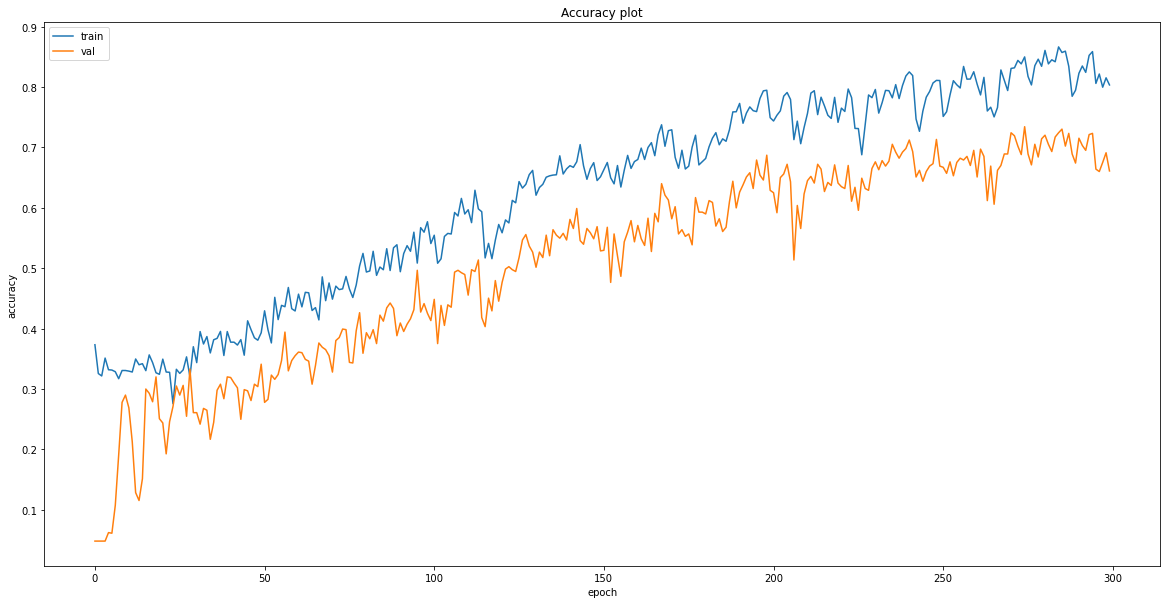

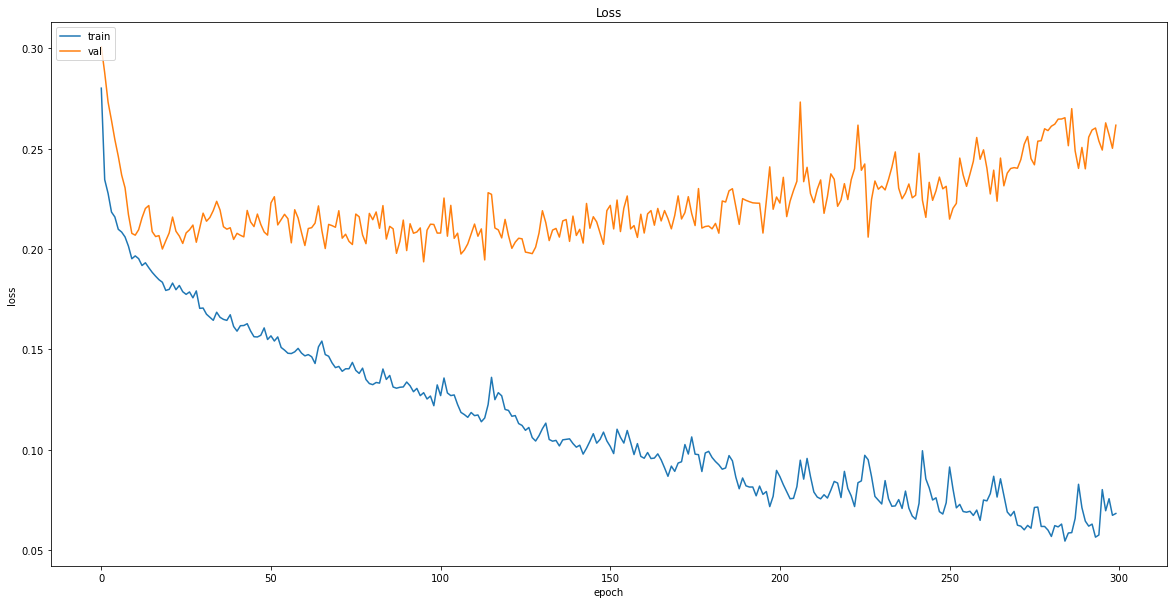

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()